Make sure that you use the right database to produce the statistics
Number of programs that are our targets: 272
Number of programs that are training targets: 204
Number of programs that are validation targets: 68
Number of programs that built successfully by ABC(all): 268
Number of programs that built successfully by ABC(training): 202
Number of programs that built successfully by ABC(validation): 66
Number of programs that are affect by ABC(larger than twice sigma)(all): 124
Number of programs that are affect by ABC(larger than twice sigma)(training): 94
Number of programs that are affect by ABC(larger than twice sigma)(validation): 30
(Geometic mean)Average speedup of (all) the ABC built programs is: 1.0091751940512714
(Geometic mean)Average speedup of (all) the ABC built programs is(> 2*sigma): 1.0134019119739919
(Geometic mean)Average speedup of (training) ABC built programs is: 1.0094314756772975
(Geometic mean)Average speedup of (training) the ABC built programs is(> 2*sigma): 1

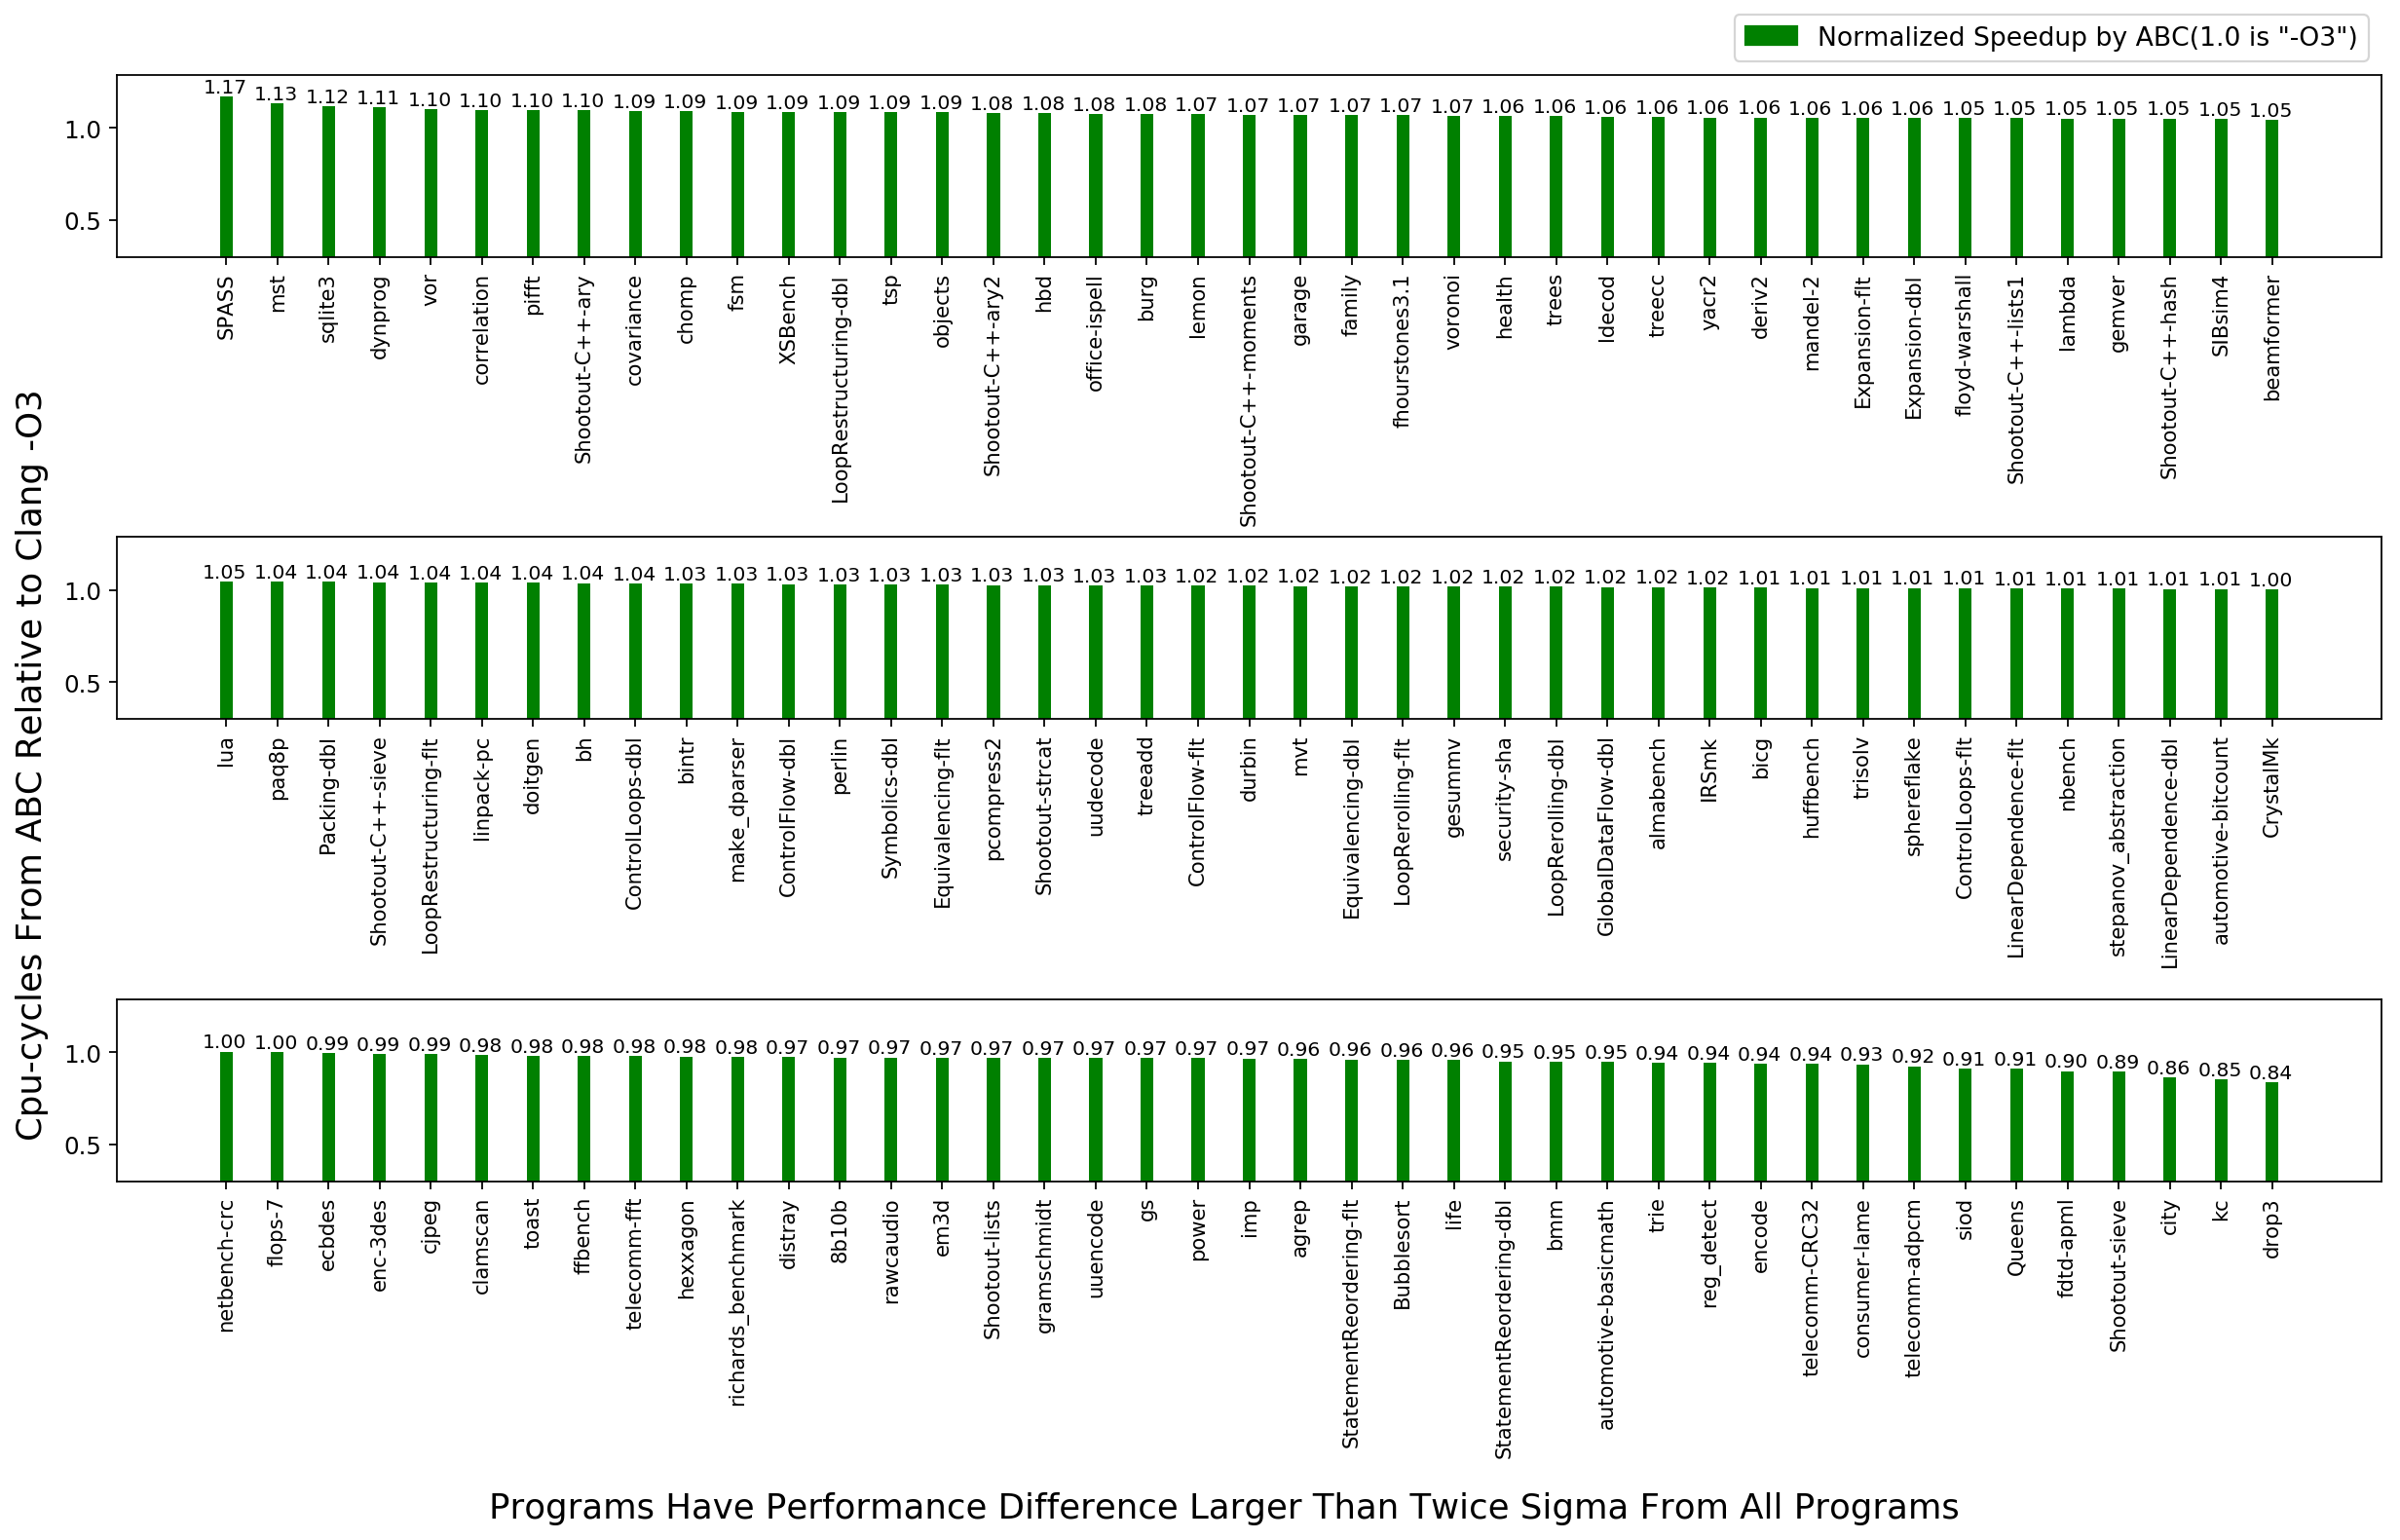

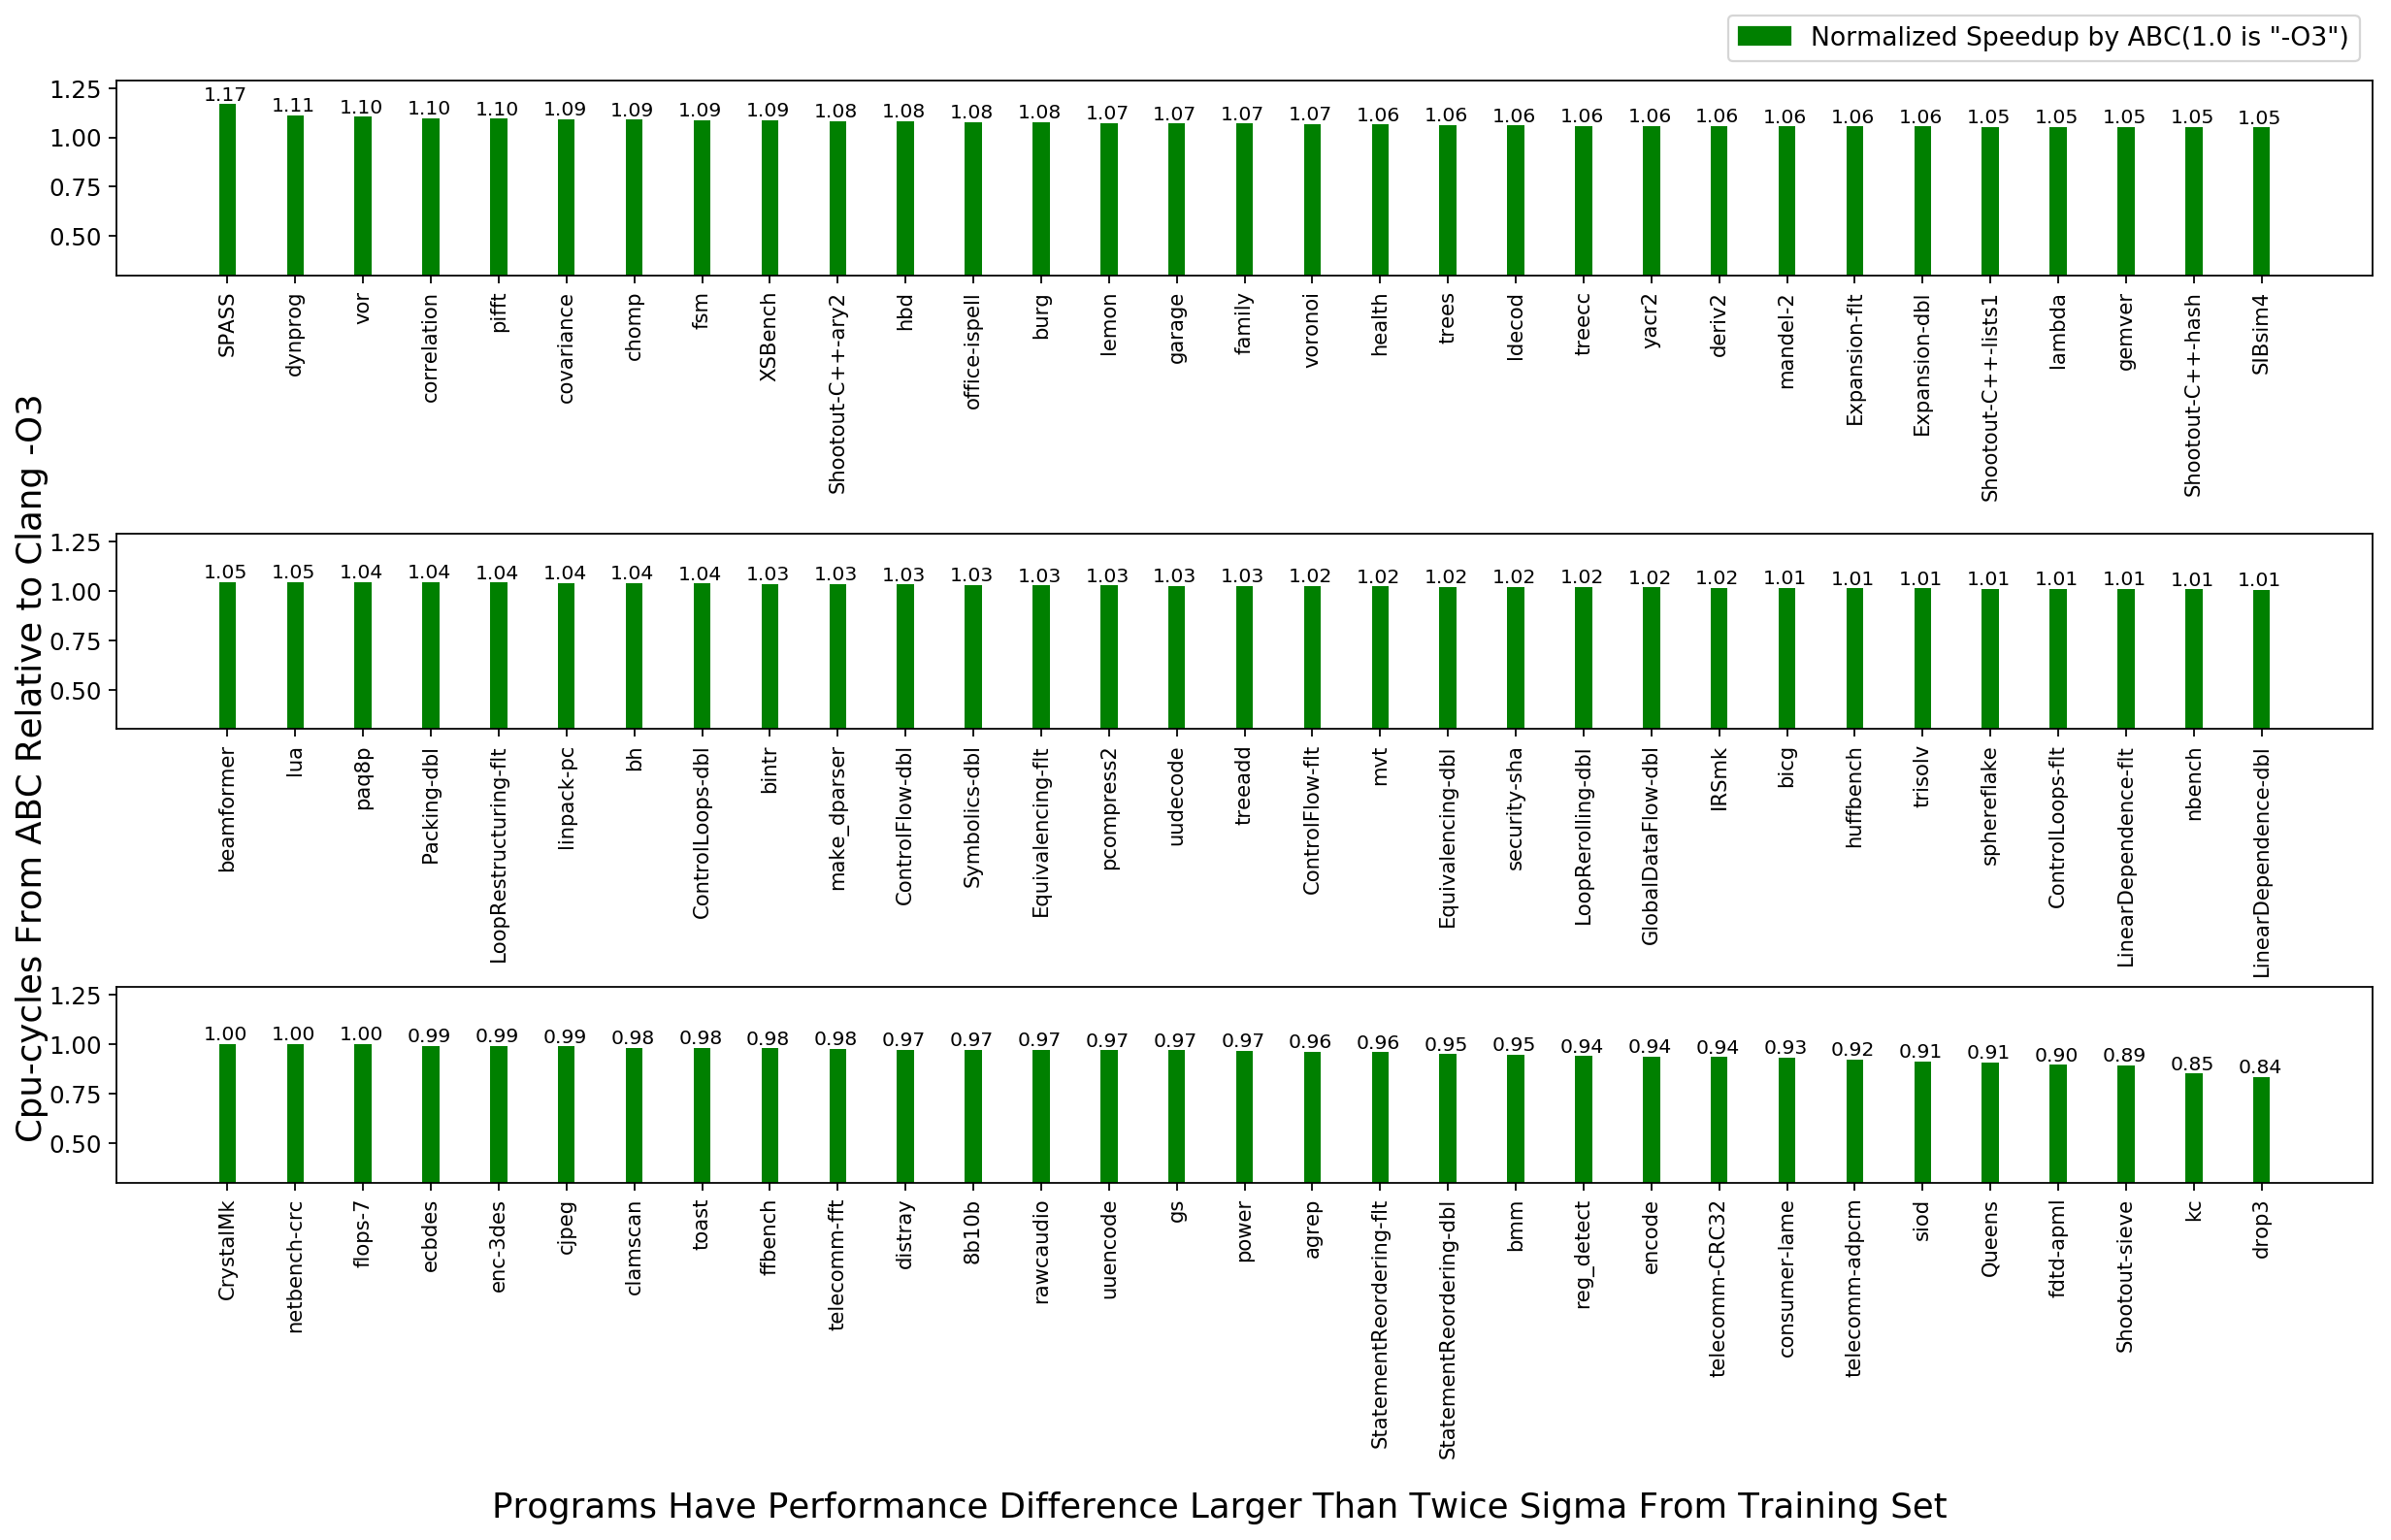

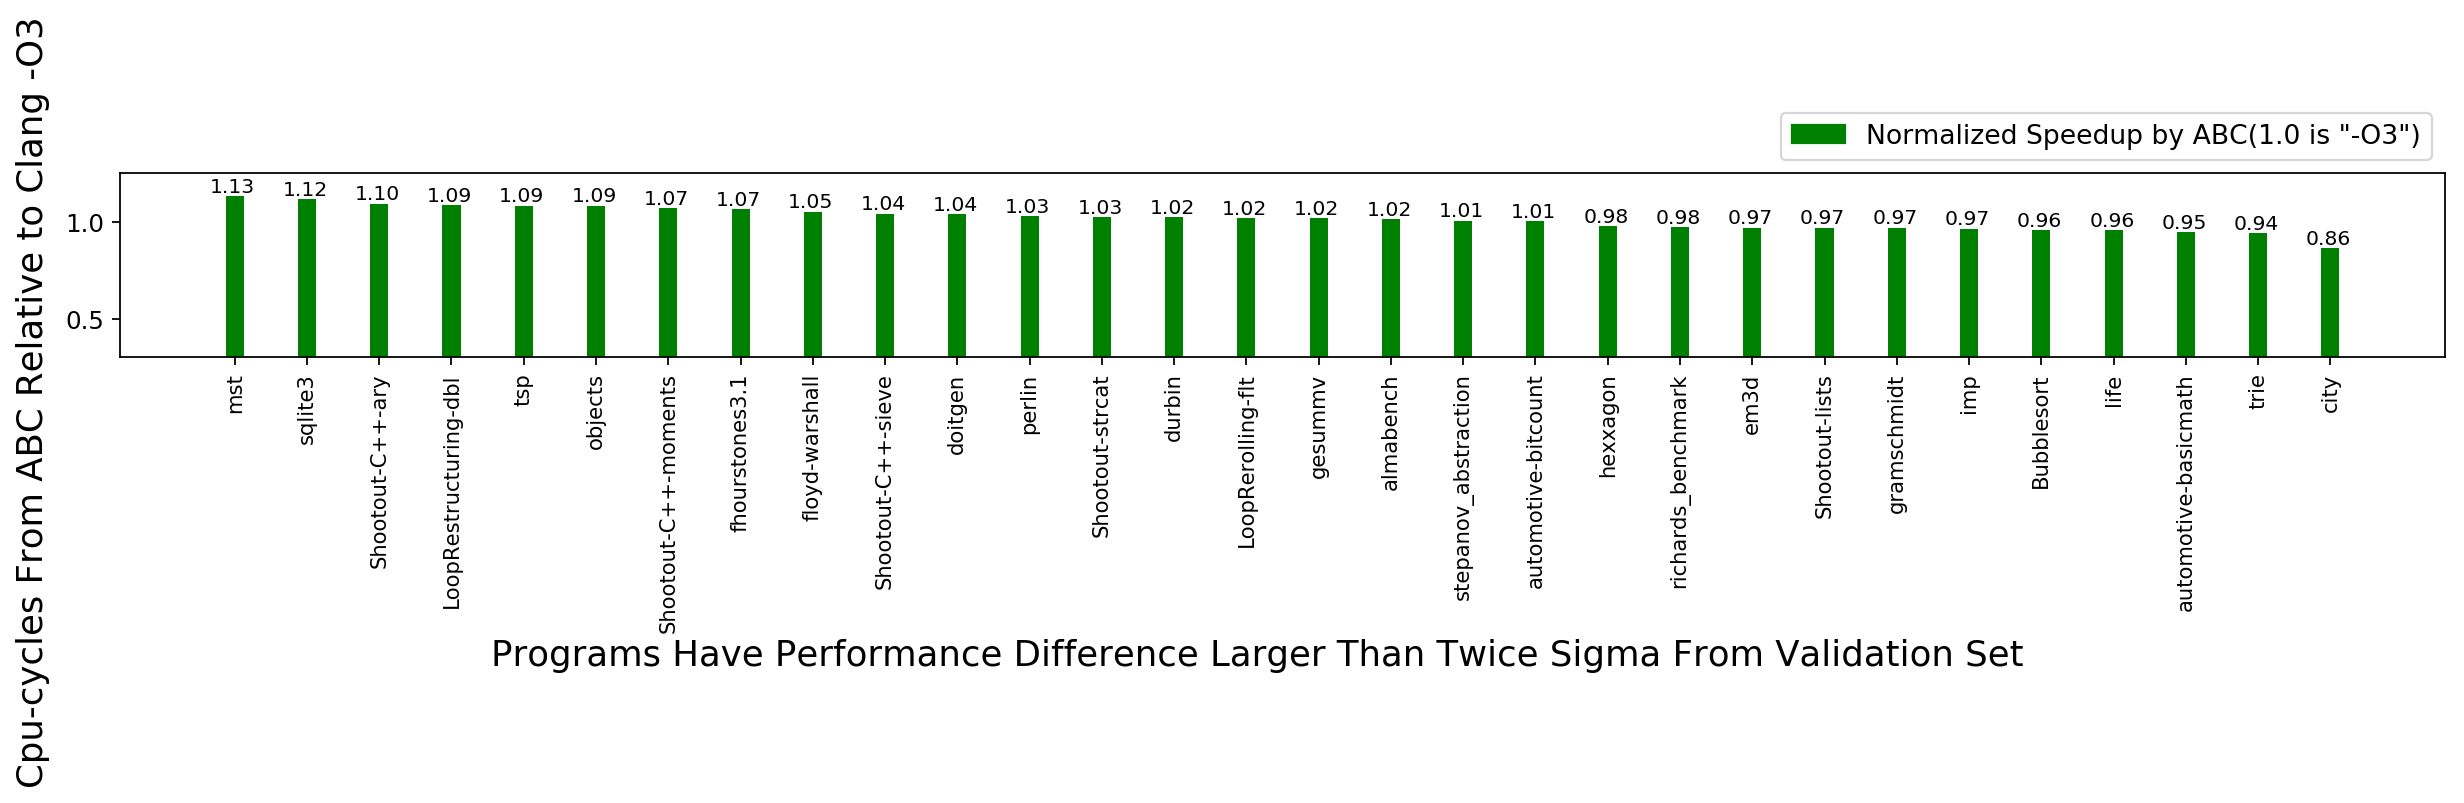

In [4]:
"""
This is the correct script for producing the figures for the thesis.
"""
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pylab as pylab
from operator import itemgetter
import copy
import operator
import functools
import os

%matplotlib inline 

def GeoMean(iterable):
    power = 1.0 / len(iterable)
    return functools.reduce(operator.mul, iterable) ** power

def GraphGenerator_AutoLabel(rects, ax, location, fontsize):
    """
    Helper function
    """
    horizontalAlign = 'center'
    if location == "up":
        verticalAlign='bottom'
    else:
        verticalAlign='top'

    for rect in rects:
        h = rect.get_height()
        label = "%.2f" % (h)
        if location == "up":
            h = h*1.0
        else:
            h = h*1.0
        ax.text(rect.get_x()+0.1, h, label,
                ha=horizontalAlign, va=verticalAlign, fontsize=fontsize)

def DrawBarChart(Inputs, Title, SaveName="Saved.png", SubGraphNum=3,  Ymax=None, Ymin=None, XbarLabel="X-label"):
    """
    Draw the bar chart
    """
    '''
    Prepare chart input
    '''
    NameList = []
    Speedup = []
    for item in Inputs:
        NameList.append(item[0])
        Speedup.append(item[1])

    x = NameList
    y = Speedup
    '''
    Draw bar chart
    '''
    plt.rc('font', size=3.5)
    params = {'legend.fontsize': 12,
          'figure.figsize': (15, 3.0*SubGraphNum),
         'axes.labelsize': 7,
         'axes.titlesize':7,
         'xtick.labelsize':9.5,
         'ytick.labelsize':11}
    pylab.rcParams.update(params)
    fig = plt.figure(dpi=160)
    width = 0.25 # the width of the bars

    # Split into N bar chart
    splitCount = SubGraphNum
    step = len(x) // splitCount
    patch_speedup = mpatches.Patch(color='green', label='Normalized Speedup by ABC(1.0 is "-O3")')
    percentage = 1/splitCount
    
    for i in range(splitCount):
        indexStart = i*step
        indexEnd = indexStart + int(percentage * len(x))

        x_sub = x[indexStart:indexEnd]
        y_sub = y[indexStart:indexEnd]
        #x_sub_order = [x for x in range(indexStart, indexEnd)]
        index = np.arange(len(x_sub))
        ax = fig.add_subplot(splitCount, 1 , i+1)

        rects = ax.bar(index, y_sub, width, color='green')
        # Do we need to limit the y axis?
        if Ymin == None and Ymax != None:
            plt.ylim(ymax=Ymax)
        elif Ymin != None and Ymax == None:
            plt.ylim(ymin=Ymin)
        elif Ymin != None and Ymax != None:
            plt.ylim(ymin=Ymin, ymax=Ymax)

        y_label_loc = "up"
        GraphGenerator_AutoLabel(rects, ax, y_label_loc, fontsize=9.2)

        XLength = len(x)
        '''
        #ax.set_ylabel('Execution Time From ABC Relative to Clang -O3: {}% - {}%'.format(round((indexStart/XLength)*100), round((indexEnd/XLength)*100)))
        if i == splitCount//2:
            ax.set_ylabel('Cpu-cycles From ABC Relative to Clang -O3', fontsize=5)
        '''
        
        ax.set_xticks(index)
        ax.set_xticklabels(x_sub, rotation=90)
        #plt.legend( handles=[patch_speedup] ) # this add legend to all subgraph
        if i == 0:
            plt.legend( handles=[patch_speedup], bbox_to_anchor=(1.0, 1.4))
    fig.text(-0.01, 0.5, 'Cpu-cycles From ABC Relative to Clang -O3', fontsize=16, ha='center', va='center', rotation='vertical')
    fig.text(0.5, -0.03, XbarLabel, fontsize=16, ha='center', va='center')

    
    fig.suptitle(Title, fontweight='bold', y=1.0)
    plt.tight_layout()
    plt.show()
    fig.savefig(SaveName, dpi=fig.dpi, bbox_inches='tight')

        
if __name__ == '__main__':
    TargetDir = "legacy_data/log-05-07_08-38"# traing: 0.9%; validation 0.8% speedup
    #TargetDir = "legacy_data/log-05-02_20-55"# traing: 1.4%; validation 1.5% speedup
    #TargetDir = "legacy_data/log-04-28_00-37"
    ABC_cycles_mean = json.load(open(TargetDir + '/' + "ABC_cycles_mean.json"))
    Orig_cycles_mean = json.load(open("Orig_cycles_mean.json"))
    Orig_cycles_sigma = json.load(open("Orig_cycles_sigma.json"))
 
    # Due to not all the results are available(some may be -1, which indicating failure)
    AvailableKeys = []
    for target, cycles in ABC_cycles_mean.items():
        if cycles != -1:
            AvailableKeys.append(target)
    SpeedupDict = {}
    '''
    SpeedupDict contains all the information that we need =)
    speedup in the dict:
        > 0: speedup
        < 0: slowdown
    '''
    TotalSpeedup = 0.0
    TotalSpeedupCount = 0
    TotalSpeedupList = []
    LargerThanTwiceSigmaSpeedupList = []
    for target in AvailableKeys:
        new = ABC_cycles_mean[target]
        old = Orig_cycles_mean[target]
        speedup = old / new
        sigma = Orig_cycles_sigma[target]
        SpeedupDict[target] = {}
        SpeedupDict[target]['new'] = new
        SpeedupDict[target]['old'] = old
        SpeedupDict[target]['speedup'] = speedup
        TotalSpeedupList.append(speedup)
        SpeedupDict[target]['sigma'] = sigma
        if speedup > 1:
            TotalSpeedupCount += 1

    AvgSpeedupAll = sum(TotalSpeedupList) / len(TotalSpeedupList)
    '''
    Discard the speedup or slow-down less than twice sigma
    '''
    SelectedSpeedupDict = copy.deepcopy(SpeedupDict)
    TotalSpeedupCountLargerThanTwice = copy.deepcopy(TotalSpeedupCount)
    for target, info in SpeedupDict.items():
        if abs(info['new'] - info['old']) < 2*info['sigma']:
            SelectedSpeedupDict.pop(target, None)
            if SpeedupDict[target]['speedup'] > 1:
                TotalSpeedupCountLargerThanTwice -= 1
        else:
            LargerThanTwiceSigmaSpeedupList.append(info['speedup'])
    AvgSpeedupLargerThanTwice = sum(LargerThanTwiceSigmaSpeedupList) / len(LargerThanTwiceSigmaSpeedupList)
#########################################################################################
    '''
    get training and validation set
    '''
    set_json = os.getenv("LLVM_THESIS_TrainingHome", "Error")
    if set_json == "Error":
        print("$LLVM_THESIS_TrainingHome is not defined.")
        sys.exit(1)
    train_json = set_json + "/trainingTargets.json"
    TrainingTargetList = json.load(open(train_json))
    valid_json = set_json + "/validationTargets.json"
    ValidationTargetList = json.load(open(valid_json))
    """
    Prepare the training and validation dict for figures and statistic.
    """
    AllTrainingInfo = {}
    AllValidationInfo = {}
    TrainingInfoLargerTwice = {}
    ValidationInfoLargerTwice = {}
    TrainingSpeedupList = []
    ValidationSpeedupList = []
    TrainingSpeedupList_sigma = []
    ValidationSpeedupList_sigma = []
    TrainingSpeedupCount = 0
    ValidationSpeedupCount = 0
    TrainingSpeedupCount_sigma = 0
    ValidationSpeedupCount_sigma = 0
    # all
    for key, info in SpeedupDict.items():
        if key in TrainingTargetList:
            AllTrainingInfo[key] = info
            TrainingSpeedupList.append(info['speedup'])
            if info['speedup'] > 1:
                TrainingSpeedupCount += 1
        elif key in ValidationTargetList:
            AllValidationInfo[key] = info
            ValidationSpeedupList.append(info['speedup'])
            if info['speedup'] > 1:
                ValidationSpeedupCount += 1
    # larger than twice sigma
    for key, info in SelectedSpeedupDict.items():
        if key in TrainingTargetList:
            TrainingInfoLargerTwice[key] = info
            TrainingSpeedupList_sigma.append(info['speedup'])
            if info['speedup'] > 1:
                TrainingSpeedupCount_sigma += 1
        elif key in ValidationTargetList:
            ValidationInfoLargerTwice[key] = info
            ValidationSpeedupList_sigma.append(info['speedup'])
            if info['speedup'] > 1:
                ValidationSpeedupCount_sigma += 1
    TrainingGraphData_sigma = []
    ValidationGraphData_sigma = []
    for target, info in TrainingInfoLargerTwice.items():
        TrainingGraphData_sigma.append([target, info['speedup']] )
    for target, info in ValidationInfoLargerTwice.items():
        ValidationGraphData_sigma.append([target, info['speedup']] )

    
    print('=============================================================================')
    print('Make sure that you use the right database to produce the statistics')
    print('=============================================================================')
    print("Number of programs that are our targets: {}".format(len(Orig_cycles_mean)))
    print("Number of programs that are training targets: {}".format(len(TrainingTargetList)))
    print("Number of programs that are validation targets: {}".format(len(ValidationTargetList)))
    print("Number of programs that built successfully by ABC(all): {}".format(len(SpeedupDict)))
    print("Number of programs that built successfully by ABC(training): {}".format(len(AllTrainingInfo)))
    print("Number of programs that built successfully by ABC(validation): {}".format(len(AllValidationInfo)))
    print("Number of programs that are affect by ABC(larger than twice sigma)(all): {}".format(len(SelectedSpeedupDict)))
    print("Number of programs that are affect by ABC(larger than twice sigma)(training): {}".format(len(TrainingInfoLargerTwice)))
    print("Number of programs that are affect by ABC(larger than twice sigma)(validation): {}".format(len(ValidationInfoLargerTwice)))
    print("(Geometic mean)Average speedup of (all) the ABC built programs is: {}".format(GeoMean(TotalSpeedupList)))
    print("(Geometic mean)Average speedup of (all) the ABC built programs is(> 2*sigma): {}".format(GeoMean(LargerThanTwiceSigmaSpeedupList)))
    print("(Geometic mean)Average speedup of (training) ABC built programs is: {}".format(GeoMean(TrainingSpeedupList)))
    print("(Geometic mean)Average speedup of (training) the ABC built programs is(> 2*sigma): {}".format(GeoMean(TrainingSpeedupList_sigma)))
    print("(Geometic mean)Average speedup of (validation) the ABC built programs is: {}".format(GeoMean(ValidationSpeedupList)))
    print("(Geometic mean)Average speedup of (validation) the ABC built programs is(> 2*sigma): {}".format(GeoMean(ValidationSpeedupList_sigma)))
    
    print("Numbers of (all) speedup programs: {}, and slowdown: {}".format(TotalSpeedupCount, len(SpeedupDict)-TotalSpeedupCount))
    print("Numbers of (all) speedup programs(larger than twice sigma): {}, and slowdown: {}".format(
        TotalSpeedupCountLargerThanTwice, len(SelectedSpeedupDict)-TotalSpeedupCountLargerThanTwice))
    print("Numbers of (training) speedup programs: {}, and slowdown: {}".format(TrainingSpeedupCount, len(TrainingSpeedupList)-TrainingSpeedupCount))
    print("Numbers of (training) speedup programs(larger than twice sigma): {}, and slowdown: {}".format(
        TrainingSpeedupCount_sigma, len(TrainingSpeedupList_sigma)-TrainingSpeedupCount_sigma))
    print("Numbers of (validation) speedup programs: {}, and slowdown: {}".format(ValidationSpeedupCount, len(ValidationSpeedupList)-ValidationSpeedupCount))
    print("Numbers of (validation) speedup programs(larger than twice sigma): {}, and slowdown: {}".format(
        ValidationSpeedupCount_sigma, len(ValidationSpeedupList_sigma)-ValidationSpeedupCount_sigma))
    print("<all> (Num of Speedup) / (Number of All) = {}".format(TotalSpeedupCount/ len(SpeedupDict)))
    print("<all> (Num of Speedup) / (Number of All) = (larger than twice sigma){}".format(TotalSpeedupCountLargerThanTwice/ len(SelectedSpeedupDict)))
    print("<training> (Num of Speedup) / (Number of All) = {}".format(TrainingSpeedupCount/ len(TrainingSpeedupList)))
    print("<training> (Num of Speedup) / (Number of All) = (larger than twice sigma){}".format(TrainingSpeedupCount_sigma/ len(TrainingSpeedupList_sigma)))
    print("<validation> (Num of Speedup) / (Number of All) = {}".format(ValidationSpeedupCount/ len(ValidationSpeedupList)))
    print("<validation> (Num of Speedup) / (Number of All) = (larger than twice sigma){}".format(ValidationSpeedupCount_sigma/ len(ValidationSpeedupList_sigma)))
    print('=============================================================================')
    print('Make sure that you use the right database to produce the statistics')
    print('=============================================================================')
    
    GraphData = []
    for target, info in SelectedSpeedupDict.items():
        GraphData.append([target, info['speedup']] )
    '''
    Sort the data in descending order for plotting graph.
    '''
    GraphData.sort(key=itemgetter(1), reverse=True)
    TrainingGraphData_sigma.sort(key=itemgetter(1), reverse=True)
    ValidationGraphData_sigma.sort(key=itemgetter(1), reverse=True)
    DrawBarChart(Inputs=GraphData, Title="",
                 SaveName = "Evaluation_Speedup-all-significance.png", SubGraphNum=3, Ymax = GraphData[0][1]+0.12, Ymin = 0.3,
                 XbarLabel = "Programs Have Performance Difference Larger Than Twice Sigma From All Programs")
    print("====================================================================")
    DrawBarChart(Inputs=TrainingGraphData_sigma, Title="",
                 SaveName = "Evaluation_Speedup-trainingSet.png", SubGraphNum=3,
                 Ymax = TrainingGraphData_sigma[0][1]+0.12, Ymin = 0.3,
                 XbarLabel = "Programs Have Performance Difference Larger Than Twice Sigma From Training Set")
    print("====================================================================")
    DrawBarChart(Inputs=ValidationGraphData_sigma, Title="",
                 SaveName = "Evaluation_Speedup-validationSet.png", SubGraphNum=1,
                 Ymax = ValidationGraphData_sigma[0][1]+0.12, Ymin = 0.3,
                 XbarLabel = "Programs Have Performance Difference Larger Than Twice Sigma From Validation Set")
    